### Execute the below cell to load the datasets

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8MB 212kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670925 sha256=5e300ee3d58bb20c5cb0ec5d1a2ce9f50be4adc00cd67314e6e48cebdf8677e4
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/assignments/'
# project_path = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1. Read and explore the dataset

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.reader import Reader
from surprise import SVD
from collections import defaultdict
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load data and rename columns

In [4]:
#Loading data
electronics_ratings = pd.read_csv(project_path + "ratings_Electronics.csv")
electronics_ratings.columns = ['userId', 'productId', 'ratings', 'timestamp']

In [5]:
electronics_ratings.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
electronics_ratings.shape

(7824481, 4)

### Drop the timestamp as it is not needed for analysis

In [7]:
electronics_ratings.drop('timestamp', axis=1, inplace=True)

In [8]:
electronics_ratings.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


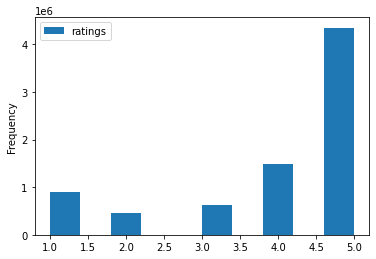

In [9]:
electronics_ratings.plot.hist()

#### The histogram above depicts that maximum people have given the rating as 5 star followed by 4, 1, 3 and 2 star

In [10]:
electronics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


## 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [11]:
filter_users = electronics_ratings['userId'].value_counts() > 50

In [12]:
filter_users

A5JLAU2ARJ0BO      True
ADLVFFE4VBT8       True
A3OXHLG6DIBRW8     True
A6FIAB28IS79       True
A680RUE1FDO8B      True
                  ...  
A2TH45PKXY5JXC    False
A1CDZC4T7626DL    False
A2Y447O0MJR932    False
A2N6XXERK2XW4W    False
A3T44GS2C2E37O    False
Name: userId, Length: 4201696, dtype: bool

In [13]:
filter_users_list = filter_users[filter_users.values == True].index.tolist()

In [14]:
len(filter_users_list)

1466

In [15]:
electronics_ratings = electronics_ratings[electronics_ratings.userId.isin(filter_users_list)]

In [16]:
electronics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 117 to 7824443
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     122171 non-null  object 
 1   productId  122171 non-null  object 
 2   ratings    122171 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


The above gives the trimmed down list with only users who have voted for more than 50 products

Trimming it further and consider products which have ratings by atleaset 10 or more users.

In [17]:
filter_products = electronics_ratings['productId'].value_counts() > 10
filter_products

B0088CJT4U     True
B003ES5ZUU     True
B000N99BBC     True
B007WTAJTO     True
B00829TIEK     True
              ...  
B004EW0P9G    False
B000EXU31E    False
B00BHZL4C0    False
B00014M2U6    False
B001G0MP74    False
Name: productId, Length: 47155, dtype: bool

In [18]:
filter_products_list = filter_products[filter_products.values == True].index.tolist()

In [19]:
electronics_ratings = electronics_ratings[electronics_ratings.productId.isin(filter_products_list)]

In [20]:
electronics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37888 entries, 21022 to 7824220
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     37888 non-null  object 
 1   productId  37888 non-null  object 
 2   ratings    37888 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


## 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [21]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(electronics_ratings[['userId', 'productId', 'ratings']], reader)

In [22]:
trainset, testset = train_test_split(data, test_size=.30)

In [23]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (123, 5.0),
              (426, 5.0),
              (404, 5.0),
              (976, 3.0),
              (795, 5.0),
              (928, 5.0),
              (808, 5.0),
              (1707, 5.0),
              (474, 5.0),
              (453, 5.0),
              (1388, 5.0),
              (868, 5.0),
              (1636, 5.0),
              (1805, 5.0),
              (829, 5.0),
              (315, 5.0),
              (1558, 5.0),
              (820, 5.0),
              (643, 5.0),
              (825, 5.0),
              (701, 5.0),
              (998, 5.0),
              (750, 5.0),
              (190, 5.0),
              (1269, 1.0),
              (1466, 5.0),
              (514, 5.0),
              (1768, 5.0),
              (1284, 5.0),
              (1040, 4.0),
              (1411, 5.0),
              (971, 5.0),
              (1016, 5.0),
              (176, 5.0),
              (681, 5.0),
              (140, 5.0),
       

## 4. Build Popularity Recommender model.

In [24]:
electronics_ratings.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00IVPU6AA    5.0
B00HZWJGS8    5.0
B000FQ2JLW    5.0
B00HG1L334    5.0
Name: ratings, dtype: float64

In [25]:
ratings_mean_count = pd.DataFrame(electronics_ratings.groupby('productId')['ratings'].mean().sort_values(ascending=False))

In [26]:
ratings_mean_count['rating_counts'] = pd.DataFrame(electronics_ratings.groupby('productId')['ratings'].count())

In [27]:
ratings_mean_count.head(10)

,ratings,rating_counts
productId,,
B00L3YHF6O,5.0,14
B00IVPU6AA,5.0,14
B00HZWJGS8,5.0,17
B000FQ2JLW,5.0,18
B00HG1L334,5.0,16
B000IJY8DS,5.0,17
B000VDCT3C,5.0,14
B0012Y6HC8,5.0,15
B007SZ0EOW,5.0,13


In [28]:
# Sorting rating 10 values based on number of counts
ratings_mean_count[ratings_mean_count.ratings == 5.0].sort_values(by="rating_counts", ascending=False).head(10)

,ratings,rating_counts
productId,,
B00ISFNSBW,5.0,18
B000FQ2JLW,5.0,18
B00HZWJGS8,5.0,17
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17
B00HG1L334,5.0,16
B005LDLP8W,5.0,15
B0012Y6HC8,5.0,15
B0033PRWSW,5.0,15


Based on the model above are the top 10 recommended items to the users.

## 5. Build Collaborative Filtering model.

In [29]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [31]:
test_pred

[Prediction(uid='A145B8OHVNNFAJ', iid='B00G4UQ6U8', r_ui=5.0, est=4.495705576650455, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='A35HNL2VEDK9Z1', iid='B002V88HFE', r_ui=5.0, est=3.7442154779515517, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AP53MVRC8ZEW2', iid='B000VX6XL6', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='APOGXH3A74CM3', iid='B008MJ01QE', r_ui=4.0, est=2.8884331419196068, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1PL7QILVQV3IF', iid='B001Q3M9D6', r_ui=2.0, est=3.872727272727272, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3V6QSTG2T9MIO', iid='B004CLYEDC', r_ui=4.0, est=5, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='A27QXQQOLAMRRR', iid='B004CLYE8C', r_ui=4.0, est=4.857855449018437, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A35A2RWUMC737N', iid='B000Q8UAWY', r_ui=5.0, est=5, details={'a

## 6. Evaluate both the models.

In [32]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9812


0.9812040788882653

#### The RMSE value is 0.9812

## 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

#### Get prediction for a few users by content based recommendation system

In [33]:
# Function to provide top 5 recommendations
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, details in predictions:
      # Only consider predicted if the model is able to predict
      # Check for was_impossible value to gaudge if can be predicted
      if(details['was_impossible'] == False):
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Lets predict recommendation for a few users from filter_users_list list

In [34]:
# Take random users
random.choices(filter_users_list, k=3)

['AMKNPIDFLRFMP', 'A30XZK10EZN9V4', 'A3EZEP0FX5BC1P']

Let's use the random users - ['AMKNPIDFLRFMP', 'A30XZK10EZN9V4', 'A3EZEP0FX5BC1P'] for our predictions

#### Prediction for user AMKNPIDFLRFMP

In [35]:
predicts= []
for item in list(set(electronics_ratings.productId)):
  # Consider only the products whose ratings are not provided by the user
  if(~(electronics_ratings[(electronics_ratings.productId == item) & (electronics_ratings.userId == 'AMKNPIDFLRFMP')].ratings.values.size > 0)):
      predicts.append(algo.predict('AMKNPIDFLRFMP', item, ''))

In [36]:
predicts

[Prediction(uid='AMKNPIDFLRFMP', iid='B00BFO14W8', r_ui='', est=3.9534790984156527, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B002SZEOLG', r_ui='', est=2.0671196361264235, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B001DJ64D4', r_ui='', est=3.904151137577549, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B006ZT4VA0', r_ui='', est=3.5789473684210527, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B00EDCF0MY', r_ui='', est=3.4821731748726656, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B000M2GYF6', r_ui='', est=3.9389659013499045, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B00D6JBZBK', r_ui='', est=3.5789473684210527, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AMKNPIDFLRFMP', iid='B003KPBRRW', r_ui

In [37]:
get_top_n(predicts)

defaultdict(list,
            {'AMKNPIDFLRFMP': [('B007PJ4PKK', 5),
              ('B002QEBMAK', 5),
              ('B0042A8CW2', 5),
              ('B000UHQVOW', 5),
              ('B002LITT42', 5)]})

The top products recommended by system (user-user based collaborative) filter are:
1. B007PJ4PKK
2. B002QEBMAK
3. B0042A8CW2
4. B000UHQVOW
5. B002LITT42

#### Prediction for user A30XZK10EZN9V4

In [38]:
predicts= []
for item in list(set(electronics_ratings.productId)):
  # Consider only the products whose ratings are not provided by the user
  if(~(electronics_ratings[(electronics_ratings.productId == item) & (electronics_ratings.userId == 'A30XZK10EZN9V4')].ratings.values.size > 0)):
      predicts.append(algo.predict('A30XZK10EZN9V4', item, ''))

In [39]:
predicts

[Prediction(uid='A30XZK10EZN9V4', iid='B00BFO14W8', r_ui='', est=4.545454545454546, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B002SZEOLG', r_ui='', est=4.0332960280071495, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B001DJ64D4', r_ui='', est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B006ZT4VA0', r_ui='', est=4.545454545454546, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B00EDCF0MY', r_ui='', est=4.545454545454546, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B000M2GYF6', r_ui='', est=4.545454545454546, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B00D6JBZBK', r_ui='', est=4.545454545454546, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B003KPBRRW', r_ui='', est=4.665

In [40]:
get_top_n(predicts)

defaultdict(list,
            {'A30XZK10EZN9V4': [('B001DJ64D4', 5),
              ('B00A83I8G2', 5),
              ('B003X26VV4', 5),
              ('B00BW6KCTU', 5),
              ('B002VPE1X4', 5)]})

The top products recommended by system (user-user based collaborative) filter are:
1. B001DJ64D4
2. B00A83I8G2
3. B003X26VV4
4. B00BW6KCTU
5. B002VPE1X4

#### Prediction for user A3EZEP0FX5BC1P

In [41]:
predicts= []
for item in list(set(electronics_ratings.productId)):
  # Consider only the products whose ratings are not provided by the user
  if(~(electronics_ratings[(electronics_ratings.productId == item) & (electronics_ratings.userId == 'A3EZEP0FX5BC1P')].ratings.values.size > 0)):
      predicts.append(algo.predict('A3EZEP0FX5BC1P', item, ''))

In [42]:
predicts

[Prediction(uid='A3EZEP0FX5BC1P', iid='B00BFO14W8', r_ui='', est=3.979725269479343, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B002SZEOLG', r_ui='', est=3.9940643187781464, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B001DJ64D4', r_ui='', est=3.614840797165175, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B006ZT4VA0', r_ui='', est=4.108695652173913, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B00EDCF0MY', r_ui='', est=5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B000M2GYF6', r_ui='', est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B00D6JBZBK', r_ui='', est=4.108695652173913, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3EZEP0FX5BC1P', iid='B003KPBRRW', r_ui='', est=1, details={'actual_

In [43]:
get_top_n(predicts)

defaultdict(list,
            {'A3EZEP0FX5BC1P': [('B00EDCF0MY', 5),
              ('B000M2GYF6', 5),
              ('B0081H8TRA', 5),
              ('B001SJVU6K', 5),
              ('B000OTF6G0', 5)]})

The top products recommended by system (user-user based collaborative) filter are:
1. B00EDCF0MY
2. B000M2GYF6
3. B0081H8TRA
4. B001SJVU6K
5. B000OTF6G0

#### Let's try recommendation for a user not in system XXXXXXXXXX

In [83]:
predicts= []
for item in list(set(electronics_ratings.productId)):
  if(~(electronics_ratings[(electronics_ratings.productId == item) & (electronics_ratings.userId == 'XXXXXXXXXX')].ratings.values.size > 0)):
      predicts.append(algo.predict('XXXXXXXXXX', item, ''))

In [84]:
predicts

[Prediction(uid='XXXXXXXXXX', iid='B002LARRDK', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B0043T7FXE', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B000075UZ7', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B00CD1FB26', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B00HMREOLK', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B004Z0S7K6', r_ui='', est=4.312016892274047, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='XXXXXXXXXX', iid='B0079M711S', r_ui='', e

In [92]:
get_top_n(predicts)

defaultdict(list, {})

No recommendation for a new user by this recommender.

As we can observer the model based on user-user collaborative model provides different recommendation based on the users historical choices.

#### Observe the recommendation from the Popularity based system

In [66]:
# Sorting rating 5 values based on number of counts
ratings_mean_count[ratings_mean_count.ratings == 5.0].sort_values(by="rating_counts", ascending=False).head(5)

,ratings,rating_counts
productId,,
B00ISFNSBW,5.0,18
B000FQ2JLW,5.0,18
B00HZWJGS8,5.0,17
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17


Any user to the system will be recomended the top 5 products based on maximum highest rating - 
B00ISFNSBW
B000FQ2JLW
B00HZWJGS8
B000IJY8DS
B001TH7GUA

## 8. Summarise your insights.

Observations from the two recommendation system suggests that the Popularity based recommendation system will just recommend the same suggestions to all the users and misses the individual choices.

On the other hand the user-user collaborative filter based on recommendation by like type users are more choice based as the recommendation is customized for individual users.

Also it can be observed that the collaborative filter suffers with cold start as it does not have any history to figure out ratings for users and hence does not suggest anything. In this case the system recommends nothing to the user. However the popularity based will recommend same 5 choices to the new user as well.

Thus, we can go with a hybrid approach to recommend new users with popularity based and existing ones with collaborative filter choice.

Also it was observed that if we take a full/large set of data for user-user based recommender system it can take a lot of time to compute the results, so making the data more dense and less sparse by dropping rows of lesser significance helps to overcome this. In the above case the strategy applied was to keep users who have provided greater than 50 ratings and products having greater than 10 ratings in the system which trimmed the data hugely providing a better and more performant model.

